# Description

Notebook for rebuttal simulation results.

# Imports

In [1]:
%load_ext autoreload
%autoreload

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import sys
import warnings

from ipywidgets import interact_manual
from linearmodels.iv import IV2SLS
from tqdm import tqdm

# user imports
sys.path.append("../")

from utils.pwr import rdd_power
from utils.sim import generate_IV_comply_indicator
from utils.clf import iv_neff, ThresholdCV

ImportError: dlopen: cannot load any more object with static TLS
___________________________________________________________________________
Contents of /home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/sklearn/__check_build:
_check_build.cpython-37m-x86_64-linux-gnu.so__pycache__               __init__.py
setup.py
___________________________________________________________________________
It seems that scikit-learn has not been built correctly.

If you have installed scikit-learn from source, please do not forget
to build the package before using it: run `python setup.py install` or
`make` in the source directory.

If you have used an installer, please check that it is suited for your
Python version, your operating system and your platform.

# Reviewer KaND: known non-compliance bias

In [24]:
def simulate_per_protocol_exclusion(n_trials, **kwargs):
    """
    Simulates per-protocol exclusion procedure.
    
    Args:
        n_trials (int): number of trials to run
        kwargs: keyword arguments for gen_iv_with_comply_status
    
    Returns:
        df: a DataFrame containing:
            - trial
            - treatment effect estimate, std error, calculated power for:
                - full data simple 2SLS
                - full data 2SLS with covariates
                - s1 exclusion estimates
                - s2 exclusion estimates
            - s1, s2 number of included samples
            - s1, s2 compliance "test set" prediction accuracy
    """    
    print("true treatment effect: {}".format(kwargs['tau']))
    # initialize data dictionary    
    data_samples = ['per_protocol']
    vals = ['tau_hat', 'std_err', 'pwr', 'n_incl', 'test_acc', 'threshold']
    df_dict = { val + "_" + data: [] for val in vals for data in data_samples}
    df_dict['trial'] = []
    
    simple_formula = 'Y ~ 1 + [T ~ Z]'
    
    for trial in range(n_trials):
        fuzzy_df = generate_IV_comply_indicator(seed=trial, **kwargs)
        feat_cols = fuzzy_df.columns[fuzzy_df.columns.str.startswith("feat")].tolist()
        extended_formula = 'Y ~ 1 + {} + [T ~ Z]'.format(' + '.join(feat_cols))

        sel_df = fuzzy_df[fuzzy_df['T'] == fuzzy_df['Z']]
        
        # simple model with per-protocl exclusion data
        populate_iv_results(df_dict, simple_formula, sel_df, kwargs['tau'], 'per_protocol')
        
        # split sample, TODO think about whether we need to stratified split on T
        np.random.seed(trial)
        
        df_dict['trial'].append(trial)
        print("trial {}".format(trial))

    return pd.DataFrame.from_dict(df_dict)

In [30]:
def run_per_protocol_simulation(n_trials, prop_complys, sim_dict, out_name):
    """
    Runs per-protocol simulation for rebuttals.
    """
    
    result_df = pd.DataFrame()
    for prop_comply in prop_complys:
        # equal proportion of never takers and always takers
        p_at = (1 - prop_comply) / 2
        p_nt = (1 - prop_comply) / 2
        sim_dict['prop_at'] = p_at
        sim_dict['prop_nt'] = p_nt

        p_df =  simulate_per_protocol_exclusion(n_trials, **sim_dict)
        p_df['prop_comply'] = prop_comply
        result_df = result_df.append(p_df)
    return result_df

## Run on same settings as Figure 3

In [36]:
tau = 0.25
n_samples = 2000
n_trials = 500
prop_complys = [0.2, 0.4, 0.6]

### Strong compliance prediction simulation

In [37]:
strong_sim_dict = dict(
        tau = tau, # true treatment effect
        n_samples = n_samples,
        use_covars = True,
        # tunes how much the covariates influence compliance
        regression_dict = dict(n_informative=5, 
                               noise=0, 
                               n_features=5)
)

strong_out_name = "strong_comply"

In [38]:
%%time

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pp_strong_df = run_per_protocol_simulation(n_trials, prop_complys, 
                        strong_sim_dict, 
                        strong_out_name)

true treatment effect: 0.25
data_df shape:1197
trial 0
data_df shape:1210
trial 1
data_df shape:1202
trial 2
data_df shape:1178
trial 3
data_df shape:1216
trial 4
data_df shape:1233
trial 5
data_df shape:1221
trial 6
data_df shape:1220
trial 7
data_df shape:1224
trial 8
data_df shape:1203
trial 9
data_df shape:1215
trial 10
data_df shape:1230
trial 11
data_df shape:1216
trial 12
data_df shape:1181
trial 13
data_df shape:1173
trial 14
data_df shape:1180
trial 15
data_df shape:1199
trial 16
data_df shape:1216
trial 17
data_df shape:1209
trial 18
data_df shape:1202
trial 19
data_df shape:1172
trial 20
data_df shape:1192
trial 21
data_df shape:1228
trial 22
data_df shape:1210
trial 23
data_df shape:1206
trial 24
data_df shape:1186
trial 25
data_df shape:1182
trial 26
data_df shape:1201
trial 27
data_df shape:1239
trial 28
data_df shape:1202
trial 29
data_df shape:1200
trial 30
data_df shape:1258
trial 31
data_df shape:1174
trial 32
data_df shape:1154
trial 33
data_df shape:1225
trial 34
da

data_df shape:1215
trial 286
data_df shape:1201
trial 287
data_df shape:1207
trial 288
data_df shape:1185
trial 289
data_df shape:1197
trial 290
data_df shape:1212
trial 291
data_df shape:1224
trial 292
data_df shape:1177
trial 293
data_df shape:1171
trial 294
data_df shape:1197
trial 295
data_df shape:1140
trial 296
data_df shape:1197
trial 297
data_df shape:1202
trial 298
data_df shape:1217
trial 299
data_df shape:1161
trial 300
data_df shape:1206
trial 301
data_df shape:1174
trial 302
data_df shape:1208
trial 303
data_df shape:1197
trial 304
data_df shape:1239
trial 305
data_df shape:1200
trial 306
data_df shape:1170
trial 307
data_df shape:1167
trial 308
data_df shape:1223
trial 309
data_df shape:1216
trial 310
data_df shape:1216
trial 311
data_df shape:1190
trial 312
data_df shape:1160
trial 313
data_df shape:1231
trial 314
data_df shape:1179
trial 315
data_df shape:1208
trial 316
data_df shape:1201
trial 317
data_df shape:1172
trial 318
data_df shape:1179
trial 319
data_df shape:

data_df shape:1409
trial 71
data_df shape:1421
trial 72
data_df shape:1399
trial 73
data_df shape:1433
trial 74
data_df shape:1410
trial 75
data_df shape:1403
trial 76
data_df shape:1403
trial 77
data_df shape:1387
trial 78
data_df shape:1388
trial 79
data_df shape:1432
trial 80
data_df shape:1382
trial 81
data_df shape:1416
trial 82
data_df shape:1401
trial 83
data_df shape:1401
trial 84
data_df shape:1381
trial 85
data_df shape:1412
trial 86
data_df shape:1438
trial 87
data_df shape:1399
trial 88
data_df shape:1397
trial 89
data_df shape:1394
trial 90
data_df shape:1388
trial 91
data_df shape:1413
trial 92
data_df shape:1419
trial 93
data_df shape:1385
trial 94
data_df shape:1378
trial 95
data_df shape:1408
trial 96
data_df shape:1415
trial 97
data_df shape:1396
trial 98
data_df shape:1398
trial 99
data_df shape:1435
trial 100
data_df shape:1390
trial 101
data_df shape:1419
trial 102
data_df shape:1404
trial 103
data_df shape:1398
trial 104
data_df shape:1414
trial 105
data_df shape:

data_df shape:1438
trial 355
data_df shape:1398
trial 356
data_df shape:1397
trial 357
data_df shape:1401
trial 358
data_df shape:1390
trial 359
data_df shape:1398
trial 360
data_df shape:1379
trial 361
data_df shape:1383
trial 362
data_df shape:1376
trial 363
data_df shape:1396
trial 364
data_df shape:1392
trial 365
data_df shape:1384
trial 366
data_df shape:1390
trial 367
data_df shape:1428
trial 368
data_df shape:1388
trial 369
data_df shape:1418
trial 370
data_df shape:1389
trial 371
data_df shape:1412
trial 372
data_df shape:1397
trial 373
data_df shape:1396
trial 374
data_df shape:1409
trial 375
data_df shape:1419
trial 376
data_df shape:1407
trial 377
data_df shape:1402
trial 378
data_df shape:1394
trial 379
data_df shape:1353
trial 380
data_df shape:1379
trial 381
data_df shape:1389
trial 382
data_df shape:1373
trial 383
data_df shape:1389
trial 384
data_df shape:1431
trial 385
data_df shape:1433
trial 386
data_df shape:1405
trial 387
data_df shape:1426
trial 388
data_df shape:

data_df shape:1614
trial 141
data_df shape:1600
trial 142
data_df shape:1611
trial 143
data_df shape:1597
trial 144
data_df shape:1594
trial 145
data_df shape:1596
trial 146
data_df shape:1589
trial 147
data_df shape:1584
trial 148
data_df shape:1601
trial 149
data_df shape:1595
trial 150
data_df shape:1594
trial 151
data_df shape:1627
trial 152
data_df shape:1598
trial 153
data_df shape:1592
trial 154
data_df shape:1626
trial 155
data_df shape:1601
trial 156
data_df shape:1579
trial 157
data_df shape:1604
trial 158
data_df shape:1623
trial 159
data_df shape:1578
trial 160
data_df shape:1596
trial 161
data_df shape:1588
trial 162
data_df shape:1625
trial 163
data_df shape:1594
trial 164
data_df shape:1572
trial 165
data_df shape:1592
trial 166
data_df shape:1596
trial 167
data_df shape:1592
trial 168
data_df shape:1601
trial 169
data_df shape:1618
trial 170
data_df shape:1608
trial 171
data_df shape:1621
trial 172
data_df shape:1609
trial 173
data_df shape:1606
trial 174
data_df shape:

data_df shape:1611
trial 424
data_df shape:1600
trial 425
data_df shape:1595
trial 426
data_df shape:1583
trial 427
data_df shape:1594
trial 428
data_df shape:1599
trial 429
data_df shape:1598
trial 430
data_df shape:1606
trial 431
data_df shape:1600
trial 432
data_df shape:1610
trial 433
data_df shape:1612
trial 434
data_df shape:1602
trial 435
data_df shape:1622
trial 436
data_df shape:1605
trial 437
data_df shape:1590
trial 438
data_df shape:1593
trial 439
data_df shape:1604
trial 440
data_df shape:1594
trial 441
data_df shape:1601
trial 442
data_df shape:1615
trial 443
data_df shape:1588
trial 444
data_df shape:1576
trial 445
data_df shape:1597
trial 446
data_df shape:1625
trial 447
data_df shape:1581
trial 448
data_df shape:1595
trial 449
data_df shape:1629
trial 450
data_df shape:1619
trial 451
data_df shape:1590
trial 452
data_df shape:1619
trial 453
data_df shape:1599
trial 454
data_df shape:1627
trial 455
data_df shape:1611
trial 456
data_df shape:1614
trial 457
data_df shape:

In [39]:
pp_strong_df.groupby("prop_comply").mean()

,tau_hat_per_protocol,std_err_per_protocol,pwr_per_protocol,n_incl_per_protocol,test_acc_per_protocol,threshold_per_protocol,trial
prop_comply,,,,,,,
0.2,0.417458,0.100127,0.704459,1200.530,NaN,NaN,249.5
0.4,0.356776,0.092720,0.769238,1400.868,NaN,NaN,249.5
0.6,0.314102,0.086677,0.822261,1601.542,NaN,NaN,249.5


In [41]:
pp_strong_df.groupby("prop_comply").std()

,tau_hat_per_protocol,std_err_per_protocol,pwr_per_protocol,n_incl_per_protocol,test_acc_per_protocol,threshold_per_protocol,trial
prop_comply,,,,,,,
0.2,0.103594,0.002168,0.018631,21.554263,NaN,NaN,144.481833
0.4,0.093585,0.001821,0.016077,18.780522,NaN,NaN,144.481833
0.6,0.088359,0.001523,0.013176,15.290646,NaN,NaN,144.481833


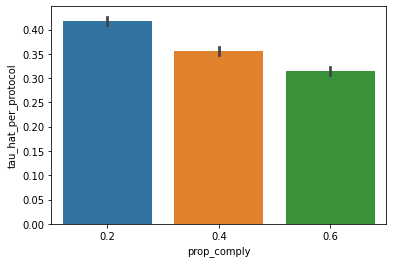

In [42]:
ax = sns.barplot(x='prop_comply', y='tau_hat_per_protocol', data=pp_strong_df)

In [53]:
taus = pp_strong_df[pp_strong_df['prop_comply'] == 0.2]['tau_hat_per_protocol']

sns.utils.ci(sns.algorithms.bootstrap(taus, n_boot=1000))

array([0.40858139, 0.4258174 ])

In [54]:
taus = pp_strong_df[pp_strong_df['prop_comply'] == 0.4]['tau_hat_per_protocol']

sns.utils.ci(sns.algorithms.bootstrap(taus, n_boot=1000))

array([0.34850962, 0.36480463])

In [55]:
taus = pp_strong_df[pp_strong_df['prop_comply'] == 0.6]['tau_hat_per_protocol']

sns.utils.ci(sns.algorithms.bootstrap(taus, n_boot=1000))

array([0.30634246, 0.32212774])

# Reviewer VPyL: number of individuals excluded (Table C.2)

In [56]:
result_dict = {}
for data_name in ['strong_comply', 'weak_comply', 'noise_comply']:
    # load data
    name_prefix = "../results/{}_p_comply".format(data_name) + "_{}.df"
    all_df = pd.DataFrame()
    x_var = 'Proportion compliers'

    for p_comply in prop_complys:
        gap_df = pd.read_pickle(name_prefix.format(p_comply))
        gap_df[x_var] = p_comply
        
        all_df = all_df.append(gap_df)
    
    result_dict[data_name] = all_df

In [76]:
for threshold in [0.2, 0.4, 0.6]: 
    print(f"Threshold: {threshold}")
    for data_name in ['strong_comply', 'weak_comply', 'noise_comply']:
        sel_df = result_dict[data_name][result_dict[data_name]['Proportion compliers'] == threshold]
        n_excl = n_samples - sel_df['data_driven_n_incl'].mean()
        print(f"{data_name}")
        print(f"{n_excl:.2f} average excluded, {n_excl / n_samples * 100:.2f}%")
        print()

Threshold: 0.2
strong_comply
1572.19 average excluded, 78.61%

weak_comply
1379.03 average excluded, 68.95%

noise_comply
110.30 average excluded, 5.52%

Threshold: 0.4
strong_comply
1169.43 average excluded, 58.47%

weak_comply
954.96 average excluded, 47.75%

noise_comply
35.95 average excluded, 1.80%

Threshold: 0.6
strong_comply
749.32 average excluded, 37.47%

weak_comply
559.50 average excluded, 27.97%

noise_comply
22.76 average excluded, 1.14%

